In [1]:
from functools import partial
import numpy as np
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import dblquad
from scipy.integrate import quad
from matplotlib import colors as c
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
import gudhi as gd
from copy import copy
import matplotlib.colors as colors

In [3]:
#Parameters 

b = 10
p = 0.5
a0= 0.01
W0 = 1
q0 = 0.005
zb = 10
hs = 0.1
hf = 0.2
rs = r = 0.5
rf = 0.5
ls = 0.5
lf = 0.2

maxl = 0.05
minl = 0.1
pl =10
zt = 2

In [4]:
#Defining function 

def a(z,zm):
    a = 2*a0 * np.exp(b*(z-zm))/(1+np.exp(b*(z-zm)) )
    return(a)

def q(z):
    q = q0* np.exp(p*z)
    return q

def W(z):
    W = W0*np.exp(w*z)- W0
    return W

def Ls(z) : 
    res = maxl -(maxl-minl)*zt**pl/(z**pl + zt**pl)
    return res

def Lf(z) : 
    res = minl -(minl-maxl)*zt**pl/(z**pl + zt**pl)
    return res

def nm(zm, z,zf, S,F,Sm, Nu0, u):
    res = Nu(zm,Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def n(z,zf, zm, S,F,Sm, Nu0, u):
    res = Nu(z, Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def nf(z,zf, zm, S,F,Sm,Nu0, u):
    res = Nu2(zf, Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def Nu(z,Nu0, u):
    nu = (Nu0 / (u* np.sqrt(2*np.pi))) * np.exp(-(zb-z)**2/(u**2))
    return nu

def f(pop,t,z,zf,zm,Nu0,u):
    S = pop[0]
    F = pop[1]
    Sm = pop[2]
    f0 =  r*S*n(z,zf,zm,S,F,Sm, Nu0, u)/(n(z,zf,zm,S,F,Sm, Nu0, u) +hs)* 1/(1+ a(z,z)*S+a(z,zm)*Sm+ a(z,zf)*F+W(z)) - Ls(z) *S
    f1 =  r*F*nf(z,zf,zm,S,F,Sm, Nu0, u)/(nf(z,zf,zm,S,F,Sm, Nu0, u) + hf)* 1/(1+ a(zf,z)*S+a(0,0)*F+W(zf)) - Lf(zf)*F
    f2= r*Sm*nm2(zm,z,zf,S,F,Sm, Nu0, u)/(nm(zm,z,zf,S,F,Sm, Nu0, u) +hs)* 1/(1+ a(zm,z)*S+a(zm,zm)*Sm+ a(zm,0)*F+W(zm)) - Ls(zm)*Sm
    f = [f0, f1,f2]
    return f

In [19]:
T = 20000 #number of time steps
dt = 1 #size of time steps

N = int(T/dt)

NX = 100 

u_val = np.linspace(0.5,10,100)

sigma2 = 0.05

epsilon = 0

time = np.linspace(0, 50000, 100)

def normale(x, sigma2) : #Gaussian distribution
    dens = 1/(np.sqrt(sigma2)*np.sqrt(2*np.pi)) *np.exp(-x**2/(2*sigma2))
    return dens 


In [20]:
#Choice of parameters
w=0.1
Nu0= 50
z0=zm = 8 #initial mean trait 
u=7
Z = np.linspace(0,zb,NX)
S = np.zeros((N,NX))
popF = np.zeros(N)
I = normale(Z-z0 , sigma2)
traj = odeint(partial(f2, z=z0, zf=0,zm=zm,Nu0 = Nu0, u =u), y0= [100, 10, 0], t=time)
S0 = traj[-1,0] 
F = traj[-1,1] + 0.1 #Initial pop of floating at ecological equilibrium (+ 0.1 if absent in order to grow later)
S[0,:] = I + 0.01 #Initial condition of submerged macro (Normal distribution + seeding)
S[0,10*z0] = 10*S0 #Initial mean trait pop size at ecological equilibrium
popF[0]=F

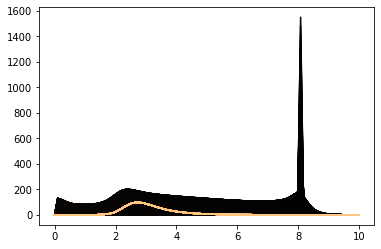

In [21]:
#Main code : Explicit euler method for the strcutrued population model evolution
for n in range(N-1) : 
    s = sum(S[n,:])*zb/NX
    z =  sum( Z *S[n,:])  / (sum(S[n,:]))
    F = odeint(partial(F2, S = s, z = z, Nu0= Nu0, u=u ), y0 = F, t=[n, n+1])[-1]
    popF[n] = F 
    for j in range(1,NX) : 
        z = Z[j]
        G = ( r* (Nu2(z, Nu0,u)/(Nu2(z, Nu0, u) + hs*(1+ sum(q(Z)* S[n,:])*zb/NX + q(0)*F))) *1/(1+ sum(a(z,Z)* S[n,:])*zb/NX+ a(z,0)*F + W(z)) - Ls(z) - epsilon  )
        A = G* S[n,j]
        B = epsilon * sum(normale(z-Z, sigma2)*S[n,:])*zb/NX
        S[n+1,j] = (S[n,j] +dt*(A+B))
    plotlabel = "t = %1.2f" %(n * dt)  
    plt.figure(1)
    plt.plot(Z,S[n,:], label=plotlabel,color = plt.get_cmap('copper')(float(n)/N))



In [ ]:
#Initial and final disctribution of the population S
plt.plot(Z, S[0,:]/max(S[0,:]), color ='red', label = 'initial')
plt.plot(Z, S[-1,:]/max(S[0,:]), color ='red', label = 'final')
plt.xlabel('trait z')
plt.legend()

In [ ]:
#Evolution of total population size of S and F
plt.figure(1)
plt.plot(range(N),(sum(np.transpose(S))*zb/NX), label= 'pop S', c='r')
plt.plot(range(N-1), popF[:N-1], label= 'pop F', c='blue')
plt.xlabel('time')
plt.ylabel('population size')
plt.legend()
plt.ylabel('population size')

Text(0.5, 1.0, 'Pop S distributions')

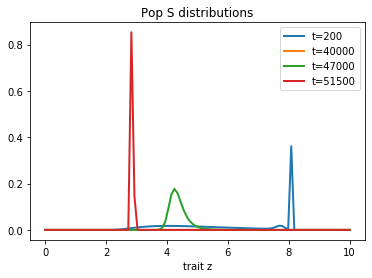

In [53]:
#Distribution of S at specific time 
for i in [200,40000,47000,51500] : 
    if sum(S[i,:])/10 > 0.5 :
        plt.plot(Z , S[i,:]/sum(S[i,:]),label='t=' + str(i), linewidth=2)
    else : 
        plt.plot(Z , S[i,:]/100, label='t='+ str(i), linewidth=2)
    plt.legend()
plt.xlabel('trait z')
plt.title('Pop S distributions')

In [ ]:
#Diagram of traits emergence of S 
TRAITS = np.zeros((NX,N))
for j in range(N) : 
    for i in range(30) : 
        TRAITS[5*i+1:5*i+5,j] = sum(S[j,5*i+1:5*i+5])/10.
        
        
palette = copy(plt.get_cmap('Reds'))
palette.set_under('white',1.0)

levels = np.arange(0, max(map(max, TRAITS)), 10)
levels[0] = 2

norm = colors.BoundaryNorm(levels, ncolors=palette.N)
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(TRAITS, cmap=palette,norm=norm,extent =[ 0,N,10,0],aspect='auto')
ax.autoscale(False)
plt.xlabel('time')
plt.ylabel('trait z')
plt.title('Presence of traits through time')
plt.colorbar()

Text(0, 0.5, 'S')

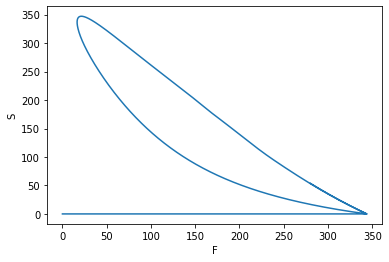

In [51]:
plt.plot(popF,(sum(np.transpose(S))*zb/NX))
plt.xlabel('F')
plt.ylabel('S')

In [71]:
#Determine final mean and median trait of S
II = []
for i in np.arange(len(S[-1,:])):
    if int(S[-1,i]) > 0:
        for k in np.arange(int(S[-1,i])):
            II.append(Z[i])
np.mean(II)
np.median(II)